In [28]:
import os
import re
import gc
import sys
import cv2
import torch
import random
import argparse
import numpy as np
import transformers
import time

torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes
torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 precision
torch.backends.cudnn.allow_tf32 = True  # Allow TF32 precision

start = time.time()
# Get the absolute path to the directory containing 'fachanwendung's parent
project_root = os.path.abspath(os.path.join("E:/Git/flask_geopixel/fachanwendung/app/static", '..', '..', '..'))

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

geopixel_path = os.path.abspath(os.path.join("E:/Git/flask_geopixel/fachanwendung/app/static", '..', '..', '..', 'GeoPixel'))

# Add the GeoPixel directory to the Python path if it's not already there
if geopixel_path not in sys.path:
    sys.path.append(geopixel_path)

model_path = os.path.abspath(os.path.join("E:/Git/flask_geopixel/fachanwendung/app/static", '...', '...', '...', 'GeoPixel', 'model'))

# Add the GeoPixel directory to the Python path if it's not already there
if model_path not in sys.path:
    sys.path.append(model_path)

# Now you can try to import from GeoPixel.chat
from GeoPixel.chat import parse_args, rgb_color_text  # Make sure rgb_color_text is imported
from model.geopixel import GeoPixelForCausalLM

def get_geopixel_result(args, objects):
    start = time.time()
    
    try:

        # Parse arguments
        try:
            args = parse_args(args)
            print(f"Arguments parsed successfully: {args}")
        except Exception as e:
            print(f"Error parsing arguments: {str(e)}")
            raise

        # Create output directory
        try:
            os.makedirs(args.vis_save_path, exist_ok=True)
            print(f"Output directory created: {args.vis_save_path}")
        except Exception as e:
            print(f"Error creating output directory: {str(e)}")
            raise

        # Initialize tokenizer
        print(f'Initializing tokenizer from: {args.version}')
        try:
            tokenizer = transformers.AutoTokenizer.from_pretrained(
                args.version,
                cache_dir=None,
                padding_side='right',
                use_fast=False,
                trust_remote_code=True,
            )
            tokenizer.pad_token = tokenizer.unk_token
            print("Tokenizer initialized successfully")
        except Exception as e:
            print(f"Error initializing tokenizer: {str(e)}")
            raise

        # Get special token indices
        try:
            seg_token_idx, bop_token_idx, eop_token_idx = [
                tokenizer(token, add_special_tokens=False).input_ids[0] for token in ['[SEG]','<p>', '</p>']
            ]
            print(f"Special token indices: SEG={seg_token_idx}, BOP={bop_token_idx}, EOP={eop_token_idx}")
        except Exception as e:
            print(f"Error getting special token indices: {str(e)}")
            raise
       
        # Prepare model arguments
        kwargs = {"torch_dtype": torch.bfloat16}
        geo_model_args = {
            "vision_pretrained": 'facebook/sam2-hiera-large',
            "seg_token_idx" : seg_token_idx, # segmentation token index
            "bop_token_idx" : bop_token_idx, # begining of phrase token index
            "eop_token_idx" : eop_token_idx  # end of phrase token index
        }
        print(f"Model arguments prepared: {geo_model_args}")

        # Clear memory
        print("Clearing GPU memory...")
        torch.cuda.empty_cache()
        gc.collect()
        
        # Load model
        print(f'Loading model from: {args.version}')
        
        # Load the model without quantization to avoid PIL.ImageFont deepcopy issues
        try:
            print("Loading model with the following parameters:")
            print(f"  - Model version: {args.version}")
            print(f"  - Low CPU memory usage: True")
            print(f"  - Device map: None (disabled to avoid meta tensor issues)")
            print(f"  - Using quantization: None (disabled to avoid PIL.ImageFont issues)")
            print(f"  - Using flash attention: True")
            
            model = GeoPixelForCausalLM.from_pretrained(
                args.version,
                low_cpu_mem_usage=True,
                **kwargs,
                **geo_model_args,
                attn_implementation="flash_attention_2"
            )
            
            # Move model to GPU manually
            model = model.to("cuda")
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            raise
        
        # Set model configuration
        try:
            model.config.eos_token_id = tokenizer.eos_token_id
            model.config.bos_token_id = tokenizer.bos_token_id
            model.config.pad_token_id = tokenizer.pad_token_id
            model.tokenizer = tokenizer
            print("Model configuration set")
        except Exception as e:
            print(f"Error setting model configuration: {str(e)}")
            raise
        
        # Set model to eval mode
        model.eval()
        print("Model set to evaluation mode")
        
        # Apply additional optimizations if available
        if hasattr(torch, 'compile'):
            try:
                print("Compiling model with torch.compile()...")
                model = torch.compile(model, mode="reduce-overhead")
                print("Model compilation successful")
            except Exception as e:
                print(f"Model compilation failed: {str(e)}")
        
        try:
            model.gradient_checkpointing_enable()
            print("Gradient checkpointing enabled")
        except Exception as e:
            print(f"Gradient checkpointing not supported: {str(e)}")

        # Prepare query and image
        try:
            query = f"Please return segmentation masks of all {', '.join(objects)}"
            print(f"Query: {query}")
            
            image_path = os.path.abspath(os.path.join("E:/Git/flask_geopixel/fachanwendung/app/static", "images", "example1-RES.jpg"))
            print(f"Image path: {image_path}")
            
            if not os.path.exists(image_path):
                print(f"Error: File not found at {image_path}")
                # Try to list files in the directory to help debugging
                try:
                    image_dir = os.path.dirname(image_path)
                    if os.path.exists(image_dir):
                        print(f"Files in {image_dir}:")
                        for file in os.listdir(image_dir):
                            print(f"  - {file}")
                    else:
                        print(f"Directory {image_dir} does not exist")
                except Exception as e:
                    print(f"Error listing directory: {str(e)}")
                raise FileNotFoundError(f"Image file not found: {image_path}")

            image = [image_path]
            print("Image prepared for processing")
        except Exception as e:
            print(f"Error preparing query and image: {str(e)}")
            raise

        # Run inference
        print("Running inference...")
        try:
            # Use CUDA streams and mixed precision for optimal performance
            cuda_stream = torch.cuda.Stream()
            with torch.cuda.stream(cuda_stream):
                with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                    with torch.no_grad():
                        response, pred_masks = model.evaluate(tokenizer, query, images=image, max_new_tokens=300)
            cuda_stream.synchronize()
            print("Inference completed successfully")
        except Exception as e:
            print(f"Error during inference: {str(e)}")
            raise
            
    except Exception as e:
        print(f"ERROR: An error occurred during model execution: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e}")
        import traceback
        traceback.print_exc()
        return None

    # Process results if we have valid masks
    try:
        if pred_masks is not None and '[SEG]' in response:
            try:
                pred_masks = pred_masks[0]
                pred_masks = pred_masks.detach().cpu().numpy()
                pred_masks = pred_masks > 0
                print(f"Masks processed: shape={pred_masks.shape}")
                
                try:
                    image_np = cv2.imread(image_path)
                    if image_np is None:
                        print(f"Warning: cv2.imread returned None for {image_path}")
                    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
                    print("Image loaded and converted to RGB")
                    
                    save_img = image_np.copy()
                    pattern = r'<p>(.*?)</p>\s*\[SEG\]'
                    matched_text = re.findall(pattern, response)
                    phrases = [text.strip() for text in matched_text]
                    print(f"Found {len(phrases)} text phrases to match with masks")

                    for i in range(pred_masks.shape[0]):
                        mask = pred_masks[i]
                        
                        color = [random.randint(0, 255) for _ in range(3)]
                        if matched_text and i < len(phrases):
                            phrases[i] = rgb_color_text(phrases[i], color[0], color[1], color[2])
                        mask_rgb = np.stack([mask, mask, mask], axis=-1)
                        color_mask = np.array(color, dtype=np.uint8) * mask_rgb

                        save_img = np.where(mask_rgb,
                                (save_img * 0.5 + color_mask * 0.5).astype(np.uint8),
                                save_img)
                    
                    if matched_text:
                        split_desc = response.split('[SEG]')
                        cleaned_segments = [re.sub(r'<p>(.*?)</p>', '', part).strip() for part in split_desc]
                        reconstructed_desc = ""
                        for i, part in enumerate(cleaned_segments):
                            reconstructed_desc += part + ' '
                            if i < len(phrases):
                                reconstructed_desc += phrases[i] + ' '
                        print(reconstructed_desc)
                    else:
                        print(response.replace("\n", "").replace("  ", " "))
                    
                    save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)
                    save_path = "{}/{}_masked.jpg".format(
                        args.vis_save_path, image_path.split("/")[-1].split(".")[0]
                        )
                    cv2.imwrite(save_path, save_img)
                    print("{} has been saved.".format(save_path))
                except Exception as e:
                    print(f"Error processing image: {str(e)}")
            except Exception as e:
                print(f"Error processing masks: {str(e)}")
        else:
            if pred_masks is None:
                print("No masks were generated")
            else:
                print("No segmentation tokens found in response")
            print(response.replace("\n", "").replace("  ", " "))
    except Exception as e:
        print(f"Error in post-processing: {str(e)}")

    # Clean up
    try:
        torch.cuda.empty_cache()
        gc.collect()
        print("Memory cleaned up")
    except Exception as e:
        print(f"Error during cleanup: {str(e)}")

    # Calculate runtime
    end = time.time()
    runtime = end-start
    print(f"Finished in {runtime} seconds.")

    return pred_masks

masks = get_geopixel_result(["--version=MBZUAI/GeoPixel-7B-RES"], ['red cars'])


Arguments parsed successfully: Namespace(version='MBZUAI/GeoPixel-7B-RES', vis_save_path='./vis_output')
Output directory created: ./vis_output
Initializing tokenizer from: MBZUAI/GeoPixel-7B-RES
Tokenizer initialized successfully
Special token indices: SEG=92550, BOP=92551, EOP=92552
Model arguments prepared: {'vision_pretrained': 'facebook/sam2-hiera-large', 'seg_token_idx': 92550, 'bop_token_idx': 92551, 'eop_token_idx': 92552}
Clearing GPU memory...
Loading model from: MBZUAI/GeoPixel-7B-RES
Loading model with the following parameters:
  - Model version: MBZUAI/GeoPixel-7B-RES
  - Low CPU memory usage: True
  - Device map: None (disabled to avoid meta tensor issues)
  - Using quantization: None (disabled to avoid PIL.ImageFont issues)
  - Using flash attention: True
Set max length to 16384


d:\ProgramFiles\miniconda\envs\gpx\lib\site-packages\torch\nn\modules\module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
d:\ProgramFiles\miniconda\envs\gpx\lib\site-packages\torch\nn\modules\module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to 

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded successfully
Model configuration set
Model set to evaluation mode
Compiling model with torch.compile()...
Model compilation successful
Gradient checkpointing enabled
Query: Please return segmentation masks of all red cars
Image path: E:\Git\flask_geopixel\fachanwendung\app\static\images\example1-RES.jpg
Image prepared for processing
Running inference...
HD is 9
orignal HW : 800 800
new HW : 1680 1680
number of patches : 9


d:\ProgramFiles\miniconda\envs\gpx\lib\site-packages\transformers\generation\utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
d:\ProgramFiles\miniconda\envs\gpx\lib\site-packages\transformers\generation\configuration_utils.py:377: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Inference completed successfully
Masks processed: shape=(1, 800, 800)
Image loaded and converted to RGB
Found 0 text phrases to match with masks
Sure, the segmentation result is [SEG] .
./vis_output/E:\Git\flask_geopixel\fachanwendung\app\static\images\example1-RES_masked.jpg has been saved.
Memory cleaned up
Finished in 879.5746953487396 seconds.


In [45]:
print(masks)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


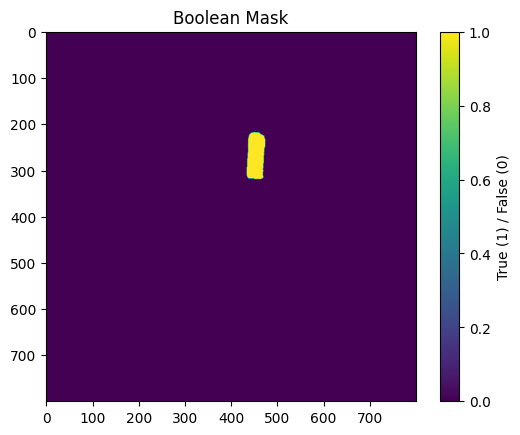

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'masks' is your 800x800 NumPy array of booleans
# For demonstration, let's create a sample boolean array:

plt.imshow(np.squeeze(masks))
plt.title('Boolean Mask')
plt.colorbar(label='True (1) / False (0)') # Optional: Add a colorbar to clarify
plt.show()

In [59]:
outline = cv2.findContours(masks.astype(np.uint8).squeeze(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
outline

((array([[[451, 218]],
  
         [[450, 219]],
  
         [[446, 219]],
  
         [[445, 220]],
  
         [[443, 220]],
  
         [[439, 224]],
  
         [[439, 227]],
  
         [[438, 228]],
  
         [[438, 231]],
  
         [[437, 232]],
  
         [[437, 247]],
  
         [[436, 248]],
  
         [[437, 249]],
  
         [[437, 262]],
  
         [[436, 263]],
  
         [[436, 274]],
  
         [[435, 275]],
  
         [[435, 293]],
  
         [[434, 294]],
  
         [[434, 312]],
  
         [[435, 313]],
  
         [[435, 315]],
  
         [[438, 318]],
  
         [[449, 318]],
  
         [[450, 319]],
  
         [[465, 319]],
  
         [[466, 318]],
  
         [[467, 318]],
  
         [[469, 316]],
  
         [[469, 313]],
  
         [[468, 312]],
  
         [[468, 304]],
  
         [[469, 303]],
  
         [[469, 300]],
  
         [[468, 299]],
  
         [[468, 297]],
  
         [[469, 296]],
  
         [[469, 286]],
  
         [[4

In [8]:
import os 
print(os.getcwd())

e:\Git\flask_geopixel\fachanwendung\app\static


'e:\\Git\\flask_geopixel\\fachanwendung\\app\\static\\images/example1-RES.jpg'

In [ ]:
import cv2
img = cv2.imread(os.path.join(os.getcwd(),"images/example1-RES.jpg"))
img.shape

array([[[170, 157, 149],
        [173, 159, 147],
        [173, 159, 147],
        ...,
        [167, 133, 110],
        [168, 133, 113],
        [166, 133, 114]],

       [[170, 157, 149],
        [173, 159, 147],
        [173, 158, 149],
        ...,
        [172, 136, 118],
        [177, 141, 123],
        [174, 139, 119]],

       [[168, 155, 147],
        [170, 158, 148],
        [170, 157, 149],
        ...,
        [179, 145, 129],
        [181, 147, 131],
        [177, 144, 124]],

       ...,

       [[106,  94,  90],
        [105,  93,  89],
        [ 95,  83,  79],
        ...,
        [ 40,  34,  27],
        [ 41,  38,  30],
        [ 42,  40,  32]],

       [[107,  95,  91],
        [ 99,  87,  83],
        [ 89,  74,  71],
        ...,
        [ 44,  36,  29],
        [ 44,  38,  31],
        [ 46,  40,  33]],

       [[111,  96,  94],
        [ 92,  77,  75],
        [ 81,  66,  64],
        ...,
        [ 48,  38,  31],
        [ 47,  39,  32],
        [ 48,  40,  33]]

In [21]:
print(img.shape)

(800, 800, 3)
